# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations[(numpy.abs(correlations) > .5)&(numpy.abs(correlations) < .9)]

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in absolute
  app.launch_new_instance()


AP Test Takers       0.523140
Total Exams Taken    0.514333
frl_percent         -0.722225
asian_per            0.570730
white_per            0.620718
Name: sat_score, dtype: float64

In [10]:
 %matplotlib inline

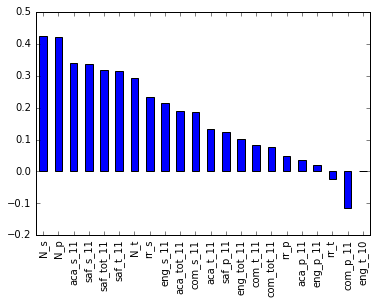

In [11]:
correlations.filter(items=survey_fields).sort_values(ascending=False).plot(kind='bar')

In [12]:
correlations.filter(items=survey_fields).sort_values(ascending=False)

N_s           0.423463
N_p           0.421530
aca_s_11      0.339435
saf_s_11      0.337639
saf_tot_11    0.318753
saf_t_11      0.313810
N_t           0.291463
rr_s          0.232199
eng_s_11      0.213822
aca_tot_11    0.190966
com_s_11      0.187370
aca_t_11      0.132348
saf_p_11      0.122913
eng_tot_11    0.100102
com_t_11      0.082419
com_tot_11    0.077310
rr_p          0.047925
aca_p_11      0.035155
eng_p_11      0.020254
rr_t         -0.023386
com_p_11     -0.115073
eng_t_10           NaN
Name: sat_score, dtype: float64

It seems academic expections is a big factor as is the number of respondents follwed by respect and safety perceptions. 

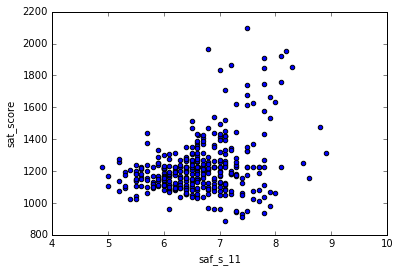

In [13]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

There does seem to be a positive trend with scatter plots. But, there is a lot of between 5 and 7 on the student safety score. 

In [14]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

In [15]:
safetyByDistrict = combined.groupby('school_dist')[['saf_s_11', 'lat', 'lon']].agg(numpy.mean)

In [16]:
safetyByDistrict.reset_index(inplace=True)
safetyByDistrict.head()

,school_dist,saf_s_11,lat,lon
0,01,6.768611,40.719022,-73.982377
1,02,6.910660,40.739699,-73.991386
2,03,6.716667,40.781574,-73.977370
3,04,6.885714,40.793449,-73.943215
4,05,6.314286,40.817077,-73.949251


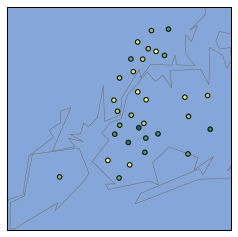

In [17]:
from mpl_toolkits.basemap import Basemap

# the base
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
#

#the points you want to plot

longitude = safetyByDistrict.lon.tolist()
latitude = safetyByDistrict.lat.tolist()

m.scatter(longitude, latitude, s=20, zorder=2, latlon=True, c=safetyByDistrict.saf_s_11, cmap='summer')

#plt.show()


Seems like non manhattan schools are les safe?


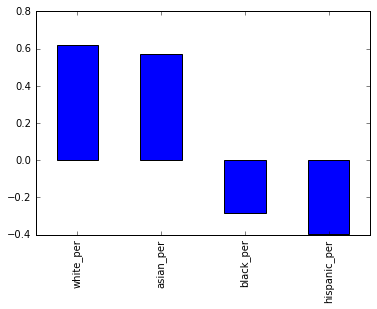

In [18]:
race_pcts=['white_per', 'asian_per', 'black_per', 'hispanic_per']

correlations.filter(items=race_pcts).sort_values(ascending=False).plot(kind='bar')


Not surisingly being white or asian is positively correlated with sat scores while being black or hispanic is negatively correlated. 

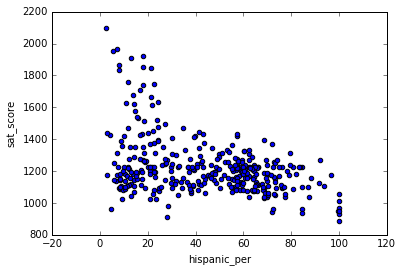

In [19]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

there does seem to be a clear downward slope for hispanic percentage. 

In [20]:
combined[combined.hispanic_per >= 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Again international schools seem to be the ones with high hispanic populations. 

In [21]:
combined[(combined.hispanic_per <= 10)&(combined.sat_score > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

All the super fancy science and technolgy schools...

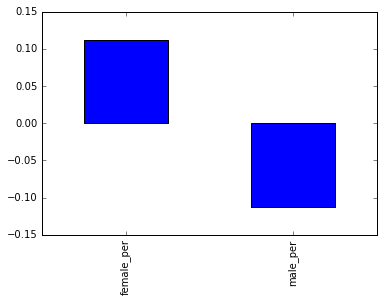

In [22]:
genderCols = ['male_per', 'female_per']

correlations.filter(items=genderCols).sort_values(ascending=False).plot(kind='bar')


Higher male percentage hurts sat performance. I could conjecture why: more violence or other non school acitvities amongst male students. But, really the correlation is just above .1, so it doesn't seem to be a particularly strong one. 

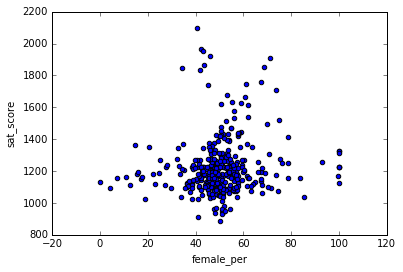

In [23]:
combined.plot.scatter(x='female_per', y='sat_score')

This plot bears out the point above. Most schools are about alanced in terms of males and females and performance varies in the middle. Some schools do great others are middling. I'd say that gender is not a strong factor. 

In [24]:
combined[(combined.female_per>.6)&(combined.sat_score > 1760)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Again, we're seeing the list of specialty schools. Students enter these schools through examinations, there are additional sources of funding. 

In [25]:
combined['ap_per']=combined['AP Test Takers ']/combined.total_enrollment

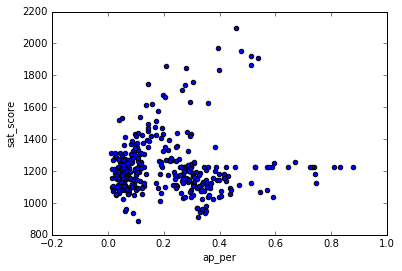

In [26]:
combined.plot.scatter(x='ap_per', y='sat_score')

Again, I see fairly weak correlation. Lot of schools bunched around 10% and then trickling to the right side of the distribution. Though SAT scores seem to one move up for some. I bet it's the same speciality schools...

In [29]:
combined[combined.sat_score>1700]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object